# Encoding and Decoding Information

Neurons' spiking patterns contain **information** about the stimulus that is causing them to fire. However, the form of this information (spike trains---series of spikes over time) can be difficult to interpret. We (as SNN authors) might want to know if these spikes are actually conveying the information that we care about or not. In order to do that, we need to **decode** the series of spikes to re-estimate the original message.

There are many theories of how information is represented in spike trains. Near the periphery, however, it appears that information is "rate-coded"---the firing rate of a spike train represents some information about the underlying stimulus. Let's take the example where we have an input in the form of an oscillating sin wave:

In [2]:
import math

def signal(t):
    return 2 * math.sin(t)

...and suppose we have the same LIF neuron model as before:

In [3]:
class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output

...and the same synapse model as before

In [4]:
class FirstOrderSynapse:
    def __init__(self, tau_s=0.01):
        self.tau_s  = tau_s # Synaptic time constant
        self.output = 0     # Current potential

    def step(self, I, t_step):
        self.output = self.output * (1 - t_step / self.tau_s) + I * t_step / self.tau_s # Decay potential
        return self.output

So we have our incoming signal, which is a scaled sin wave...

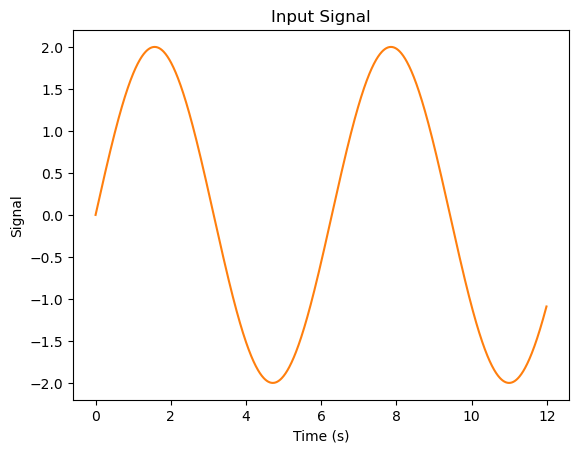

In [11]:
import matplotlib.pyplot as plt
import numpy as np

neuron = FirstOrderLIF()
psp = FirstOrderSynapse(tau_s = 0.15)

# plot signal vs time for 12 seconds
t_step = 0.01
t = np.arange(0, 12, t_step)
signal_out = []
psp_out = []
for i in t:
    sig = signal(i)
    neuron.step(sig, t_step)
    psp.step(neuron.output, t_step)
    signal_out.append(sig)
    psp_out.append(psp.output)

plt.figure()
plt.plot(t, signal_out, color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Input Signal')
plt.show()

...and we have our output for that signal for a single neuron.

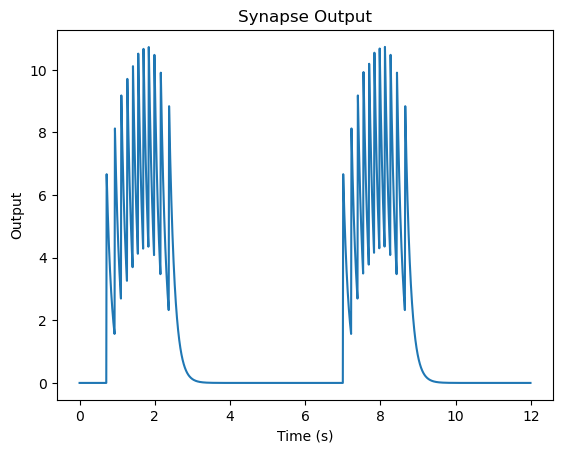

In [6]:
plt.figure()
plt.plot(t, psp_out)
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Synapse Output')
plt.show()

We can see that while our signal is high, our neuron fires. When our signal is low, it doesn't fire. Now, suppose we wanted to get a sense of how well our neuron represents our original signal. One way to (roughly) know this is by trying to re-construct our original signal based on our neuron/synapse output.

We can do this by finding a single number, $\phi{}$, that we can multiply our synapse output by in order to estimate our original signal. We can calculate $\phi{}$ by first choosing a set of potential input values (that represent the range of our inputs) with "low" (the lowest input value), "high" (the highest input value), and "$\delta$" (the size of increments between "low" and "high"):

$$
\phi{} = \frac{\sum_{i \in I} ir(i)}{\sum_{i \in I} r(i)^2}\\
I = \{\text{low}, \text{low}+\delta, \text{low}+2\delta, \ldots, \text{high}-\delta, \text{high}\}
$$(eq:single-neuron-decoder)

Where $r(i)$ is the firing rate of the neuron for input $i$.

:::{dropdown} Where does this come from?
So how can we try to re-construct our original signal based just on the firing rate? Suppose we have a firing rate $r(i)$ as a function of input $i$.

So let's define a weighting term $\phi{}$ that we can multiply $r(I)$ by in order to estimate our signal. We will estimate our signal as $\phi{}r(I)$. We can calculate the mean squared error (MSE) of our estimate as the actual input ($I$) minus the estimate:

$E(I) = \frac{1}{2}[I - r(I)\phi{}]^2$

...but really, we want to minimize our error across multiple values of $I$ (not just one). So we choose an interval over which we want to minimize error. Let's use *"low"* and *"high"* as stand-ins for the lower and upper bounds of this interval. We ultimately can calculate the error as:

$$E = \int_{\text{low}}^{\text{high}} \frac{1}{2}[x - r(x)\phi{}]^2 \,dx$$

To minimize this, we want to find the lowest point of the error curve, which is where $\frac{dE(x)}{d\phi} = 0$:

$$\frac{dE(x)}{d\phi} = \int-2r(x)\frac{1}{2}[x - r(x)\phi{}] \,dx$$
$$\frac{dE(x)}{d\phi} = \int[-xr(x) + \phi{}r(x)^2]dx$$

If we set this equal to zero, we have:

$$\int xr(x)dx = \int \phi{}r(x)^2dx$$

Since $\phi{}$ does not vary with respect to input $x$, we can take it outside of the integral and compute its value as:

$$\phi{} = \frac{\int_{\text{low}}^{\text{high}} xr(x)dx}{\int_{\text{low}}^{\text{high}}r(x)^2dx}$$

We can then estimate the numerator and denominator by computing them over several fixed intervals. Replacing the integrals with summations, we get:

$$
\phi{} = \frac{\sum_{i \in I} ir(i)\delta}{\sum_{i \in I} r(i)^2\delta}\\
I = \{\text{low}, \text{low}+\delta, \text{low}+2\delta, \ldots, \text{high}-\delta, \text{high}\}
$$
:::
<!-- For convenience, we will assign the variables $\upsilon{} = \int_{\text{low}}^{\text{high}}xr(x)dx$ and $\gamma{} = \int_{\text{low}}^{\text{high}}r(x)^2dx$ so we end up with: -->

<!-- $$\phi{} = \gamma{}^{-1}\upsilon{}$$ -->

We can compute $r(i)$ analytically using our formula from earlier {eq}`eq:analytical-rate`:

$$
r(I) =
\begin{cases}
  0 & \text{if } I \leq v_{th}\\
  \frac{1}{\tau_{ref}-\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}} & \text{otherwise}
\end{cases}
$$

In [7]:
def analyticalRate(neuron, I):
    if I <= neuron.v_th: return 0
    else:                return 1 / (neuron.tau_ref - neuron.tau_rc * np.log(1 - neuron.v_th/I))

Then, we can compute $\phi{}$ using the formula in {eq}`eq:single-neuron-decoder`

In [8]:
def computeDecoder(neuron, range_low=-1, range_high=1, interval=0.1):
    numerator   = 0
    denominator = 0
    for i in np.arange(range_low, range_high, interval):
        r = analyticalRate(neuron, i)
        numerator   += r*i
        denominator += r*r
    return numerator / denominator

In [12]:
decoder = computeDecoder(neuron, -2, 2)
print(decoder)

0.3229210069532396


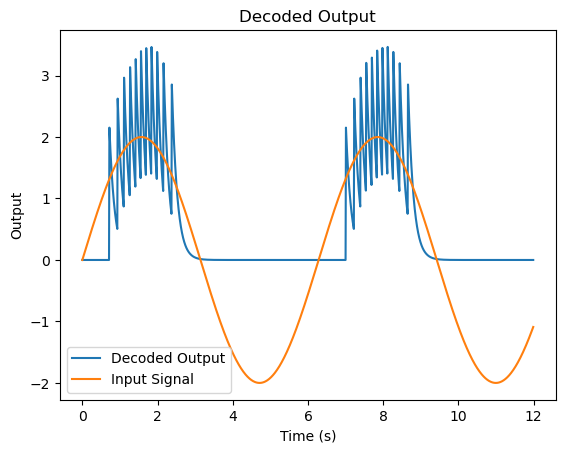

In [10]:

decoded_output = [decoder * o for o in psp_out]

plt.figure()
plt.plot(t, decoded_output)
plt.plot(t, signal_out)
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Decoded Output')
plt.legend(['Decoded Output', 'Input Signal'])
plt.show()

We can see that our estimate *kind of* captures some of the highs of our input signal but not much else. Instead of just having **one** neuron, next section, we will see how we can instead represent our signal with multiple neurons to get a better result.

# Resources

- Chris Eliasmith's [Neural Engineering book](https://mitpress.mit.edu/9780262550604/neural-engineering/) contains the derivation used for computing decoders
- Nengo's [NEF Algorithm code](https://www.nengo.ai/nengo/examples/advanced/nef-algorithm.html) is a good example of how to build and understand encoders